In [1]:
import gspread
import pandas as pd
import numpy as np

In [2]:
cread_file='iron-dynamics-304717-d77dd1c57cb1.json'
gc=gspread.service_account(cread_file)

In [3]:
database=gc.open('Income / Expense')
update=gc.open('Final Report')
bse=gc.open('BSE500')

In [4]:
wks=database.worksheet('inex')
final=update.worksheet('Sheet1')
fi=bse.worksheet('bse500')
fill=update.worksheet('Sheet2')

In [6]:
ei=pd.DataFrame(wks.get_all_values(),columns=['Date','Payment_Mode','Category','Subcategory','Note','INR','Income/Expense','Amount','Currency'])
ei.drop(columns=['Amount','Currency'],inplace=True)
ei.drop(index=0,inplace=True)

In [7]:
ei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 1 to 277
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            277 non-null    object
 1   Payment_Mode    277 non-null    object
 2   Category        277 non-null    object
 3   Subcategory     277 non-null    object
 4   Note            277 non-null    object
 5   INR             277 non-null    object
 6   Income/Expense  277 non-null    object
dtypes: object(7)
memory usage: 15.3+ KB


In [8]:
#preprocessing
ei['Date']=pd.to_datetime(ei['Date'])
ei['INR']=pd.to_numeric(ei['INR'])

In [75]:
#Increasing salary
ei.loc[139,'INR']=20000

In [77]:
#Updating Net Income and Net Expense
Net_income=ei[ei['Income/Expense']=='Income']['INR'].sum()
Net_expense=ei[ei['Income/Expense']=='Expense']['INR'].sum()
final.update_cell(7,3,Net_income)
final.update_cell(8,3,Net_expense)

{'spreadsheetId': '1oWn-6TcHJichTXKQHWFuPIayQt6lhxK3NgBNYCZrgLY',
 'updatedRange': 'Sheet1!C8',
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

In [78]:
#Updating Net Expense in various categoreis
for i in ei.Category.unique():
    try:
        word=i
        cell=final.find(word)
        a=ei[(ei['Category']==i) & (ei['Income/Expense']=='Expense')]['INR'].sum()
        final.update_cell(cell.row,cell.col+1,a)
    except:
        None

In [61]:
#filling Funds Available for investing
final.update_cell(24,3,Net_income-Net_expense)    

{'spreadsheetId': '1oWn-6TcHJichTXKQHWFuPIayQt6lhxK3NgBNYCZrgLY',
 'updatedRange': 'Sheet1!C24',
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

In [11]:
stocks=pd.DataFrame(fi.get_all_records())

In [12]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Company                   501 non-null    object 
 1   BSE code                  501 non-null    int64  
 2   NSE code                  501 non-null    object 
 3   ISIN                      501 non-null    object 
 4   Sector                    501 non-null    object 
 5   Industry                  501 non-null    object 
 6   Date                      501 non-null    object 
 7   Price                     501 non-null    float64
 8   1 day change(%)           501 non-null    float64
 9   52 Week Low               501 non-null    float64
 10  52 Week High              501 non-null    float64
 11  3 Year Low                501 non-null    object 
 12  3 Year High               501 non-null    object 
 13  5 Year Low                501 non-null    object 
 14  5 Year Hig

In [13]:
stocks['Delta'].replace(to_replace='',value=0,inplace=True)
stocks['Dividend Per Share'].replace(to_replace='',value=0,inplace=True)

In [114]:
stocks.columns

Index(['Company', 'BSE code', 'NSE code', 'ISIN', 'Sector', 'Industry', 'Date',
       'Price', '1 day change(%)', '52 Week Low', '52 Week High', '3 Year Low',
       '3 Year High', '5 Year Low', '5 Year High', 'All Time Low',
       'All Time High', 'Market Cap(Cr)', 'Enterprise Value(Cr)',
       '1-Week Return', '1-Month Return', '3-Month Return(%)',
       '1-Year Return(%)', '3-Year Return', '5-Year Return(%)',
       '10-Year Return(%)', 'Price to Earnings', 'Median P/E', 'Price to Book',
       'Median P/B', 'Earning Yield(%)', 'Price earnings to growth',
       'Dividend Yield(%)', 'EV / EBITDA', 'Price / Sales',
       'Price / Cash Flow', 'Earning Per Share', 'Book Value Per Share',
       'Cash Flow Per Share', 'Free Cash Flow Per Share', 'Dividend Per Share',
       'Delta'],
      dtype='object')

In [117]:
stocks['Delta']=pd.to_numeric(stocks['Delta'])
stocks['Dividend Per Share']=pd.to_numeric(stocks['Dividend Per Share'])
stocks['10-Year Return(%)']=pd.to_numeric(stocks['10-Year Return(%)'])
stocks['3-Year Return']=pd.to_numeric(stocks['3-Year Return'])
stocks['Median P/E']=pd.to_numeric(stocks['Median P/E'])
stocks['5-Year Return(%)']=pd.to_numeric(stocks['5-Year Return(%)'])
stocks['10-Year Return(%)']=pd.to_numeric(stocks['10-Year Return(%)'])
stocks['1-Year Return(%)']=pd.to_numeric(stocks['1-Year Return(%)'])

In [16]:
#Creating Delta column in BSE sheet
fi.add_cols(1)
cell_list=fi.range('AP2:AP501')
for i,val in enumerate(cell_list):
    val=((stocks.iloc[i]['52 Week High']-stocks.iloc[i]['Price'])/(stocks.iloc[i]['52 Week High']))
    cell_list[i].value=val
fi.update_cells(cell_list)
    

{'spreadsheetId': '1d-tLU4D0DA094BK1CIuwMWzny5U5SMI7Xjq052ESujM',
 'updatedRange': "'bse500'!AP2:AP501",
 'updatedRows': 500,
 'updatedColumns': 1,
 'updatedCells': 500}

In [72]:
#Stock selection Criteria
Criteria={'High Risk Taking':{'Market Cap(Cr)':[stocks['Market Cap(Cr)'].min(),2000],'10-Year Return(%)':[stocks['10-Year Return(%)'].min(),8]},'Risk Taking':{'Market Cap(Cr)':[2000,5000],'10-Year Return(%)':[8,15]},'Moderate Risk Taking':{'Market Cap(Cr)':[5000,15000],'10-Year Return(%)':[15,20]},'Low Risk Taking':{'Market Cap(Cr)':[15000,stocks['Market Cap(Cr)'].max()],'10-Year Return(%)':[20,stocks['10-Year Return(%)'].max()]}}

In [112]:
#selecting stock Based on risk apetite
Risk_profile=final.cell(27,3).value
for risk,factor in Criteria.items():
    try:
        if risk==Risk_profile:
            new=stocks[stocks['Delta']>0]
            for cols,nums in factor.items():
                new=new[(new[cols]>=nums[0]) & (new[cols]<nums[1])]
        companies=new.sort_values(by='Dividend Per Share',ascending=False)['Company'].iloc[0:7].values
    except:
        None
cell_list2=fill.range('B2:B8')
cell_list4=fill.range('C2:C8')
Amount_to_be_invested=final.cell(24,3).value
for i,val in enumerate(cell_list2):
    try:
        val=companies[i]
        cell_list2[i].value=val
    except:
        cell_list2[i].value='NA'
fill.update_cells(cell_list2)
for i,val in enumerate(cell_list4):
    try:
        if i in range(len(companies)):
            cell_list4[i].value=(int(Amount_to_be_invested)/len(companies))
        else:
            cell_list4[i].value=''
            
    except:
        None
        
fill.update_cells(cell_list4)

{'spreadsheetId': '1oWn-6TcHJichTXKQHWFuPIayQt6lhxK3NgBNYCZrgLY',
 'updatedRange': 'Sheet2!C2:C8',
 'updatedRows': 7,
 'updatedColumns': 1,
 'updatedCells': 7}

In [25]:
import matplotlib.pyplot as plt

In [48]:
stocks['Enterprise Value(Cr)']=pd.to_numeric(stocks['Enterprise Value(Cr)'])

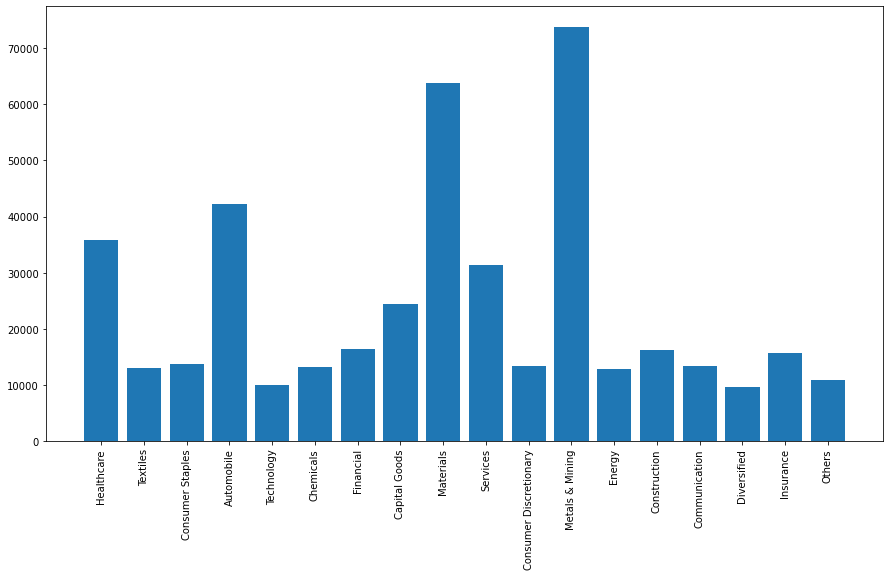

In [49]:
plt.figure(figsize=(15,8))
plt.bar(stocks.Sector.unique(),stocks.groupby('Sector')['Enterprise Value(Cr)'].median().values)
plt.xticks(rotation=90)
plt.show()

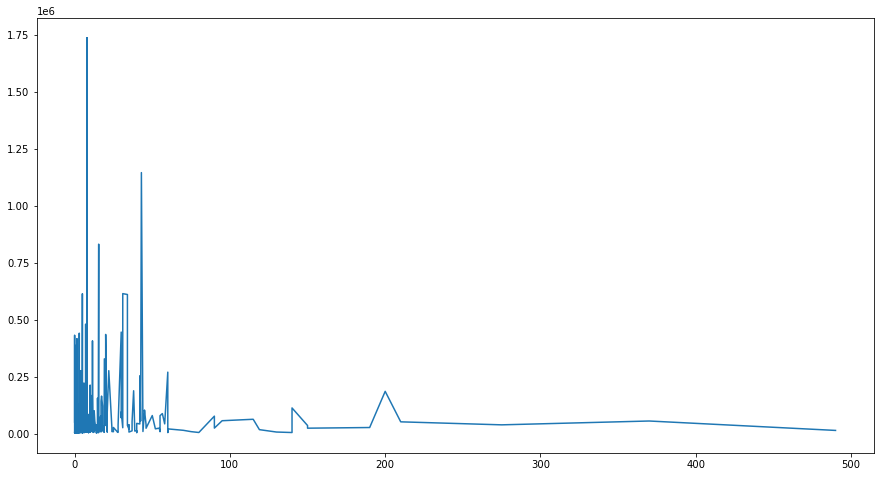

In [404]:
fig=plt.figure(figsize=(15,8))
plt.plot(stocks['Dividend Per Share'],stocks['Market Cap(Cr)'])

In [27]:
stocks['3-Year Return']=pd.to_numeric(stocks['3-Year Return'])

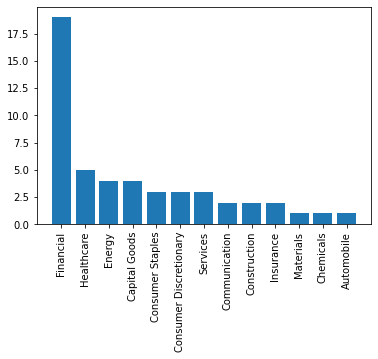

In [45]:
df2=stocks[stocks['3-Year Return']<0]['Sector'].value_counts()

plt.bar(df2.index,df2.values)
plt.xticks(rotation=90)
plt.show()

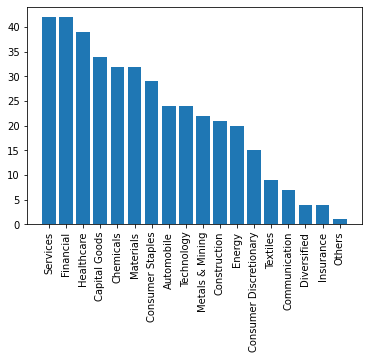

In [44]:
df3=stocks[stocks['3-Year Return']>0]['Sector'].value_counts()

plt.bar(df3.index,df3.values)
plt.xticks(rotation=90)
plt.show()

In [119]:
#KPI Calculation
stocks['KPI']=0.3*stocks['Median P/E']+0.3*stocks['10-Year Return(%)']+0.23*stocks['5-Year Return(%)']+0.17*stocks['1-Year Return(%)']